In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [2]:
# Download stopwords if you haven't already
nltk.download('stopwords')

# Load your data (replace 'Reviews.csv' with your actual file path)
data = pd.read_csv(r'C:\Users\masha\git\NEEC\Reviews.csv')

# Filter profiles and perform preprocessing as per your original process
profile_counts = data['ProfileName'].value_counts()
valid_profiles = profile_counts[profile_counts >= 100].index
filtered_df = data[data['ProfileName'].isin(valid_profiles)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\masha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Classify scores into positive/negative
def classify_score(score):
    if score < 3:
        return 0
    else:
        return 1


In [4]:
actualScore = filtered_df['Score']
positiveNegative = actualScore.map(classify_score)
filtered_df['Score'] = positiveNegative

sorted_data = filtered_df.sort_values('ProfileName', axis=0, ascending=True)
sorted_data.head

C:\Users\masha\AppData\Local\Temp\ipykernel_30324\498831228.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Score'] = positiveNegative


<bound method NDFrame.head of             Id   ProductId          UserId                        ProfileName  \
42626    42627  B001EQ4E60    ACYR6O588USK  '  Groovin' guy "music historian"   
539539  539540  B006WYSFZK    ACYR6O588USK  '  Groovin' guy "music historian"   
134696  134697  B003ZXHDGS    ACYR6O588USK  '  Groovin' guy "music historian"   
564538  564539  B002K74V3S    ACYR6O588USK  '  Groovin' guy "music historian"   
228736  228737  B0058AMY10    ACYR6O588USK  '  Groovin' guy "music historian"   
...        ...         ...             ...                                ...   
12835    12836  B000YV7WBU  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
554169  554170  B000LKTKZ0  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
420739  420740  B001EQ5GG2  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
288466  288467  B000ENUC3S  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
482302  482303  B0018KLPFK  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"  

In [5]:
# removing duplicate entries
final = sorted_data.drop_duplicates(subset={"UserId", "ProfileName" ,"Time", "Text"}, keep = 'first', inplace = False)
print(final["Score"])

42626     1
539539    1
134696    1
564538    1
71087     1
         ..
200902    1
321641    1
12835     1
554169    1
420739    1
Name: Score, Length: 16068, dtype: int64


In [6]:
# Separate positive and negative samples
positive_samples = final[final['Score'] == 1]
negative_samples = final[final['Score'] == 0]

print(positive_samples, negative_samples)

            Id   ProductId          UserId                        ProfileName  \
42626    42627  B001EQ4E60    ACYR6O588USK  '  Groovin' guy "music historian"   
539539  539540  B006WYSFZK    ACYR6O588USK  '  Groovin' guy "music historian"   
134696  134697  B003ZXHDGS    ACYR6O588USK  '  Groovin' guy "music historian"   
564538  564539  B002K74V3S    ACYR6O588USK  '  Groovin' guy "music historian"   
71087    71088  B004IN7CJ2    ACYR6O588USK  '  Groovin' guy "music historian"   
...        ...         ...             ...                                ...   
200902  200903  B000JJK0B6  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
321641  321642  B001GQ3E3M  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
12835    12836  B000YV7WBU  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
554169  554170  B000LKTKZ0  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   
420739  420740  B001EQ5GG2  A1LZJZIHUPLDV4  vegancompassion "anattanupassana"   

        HelpfulnessNumerato

In [7]:
# Randomly sample from positive samples to match the number of negative samples
positive_sampled = positive_samples.sample(n=len(negative_samples), random_state=42)

In [8]:
# Combine the sampled positive samples with the negative samples
balanced_df = pd.concat([positive_sampled, negative_samples])

In [9]:
# Shuffle the dataset to mix positive and negative samples
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
# Display the counts after balancing
score_counts_balanced = balanced_df['Score'].value_counts()
print("Score Counts after sampling:", score_counts_balanced)

final = balanced_df

final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
print(final.shape)

score_counts = final['Score'].value_counts()

Score Counts after sampling: Score
1    2057
0    2057
Name: count, dtype: int64
(4114, 10)


In [11]:
# Preprocess the text data
stop = set(stopwords.words('english'))  # Set of stopwords
sno = SnowballStemmer('english')  # Initialize Snowball Stemmer

# Function to clean HTML tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    return re.sub(cleanr, ' ', sentence)

# Function to remove punctuation
def cleanpunc(sentence):
    return re.sub(r'[?|!|\'|"|#]', r'', sentence)

# Preprocess the 'Text' column
final_string = []
list_of_sent = []

for sent in final['Text']:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_word in cleanpunc(w).split():
            if cleaned_word.isalpha() and len(cleaned_word) > 2:
                word_lower = cleaned_word.lower()
                if word_lower not in stop:
                    stemmed_word = sno.stem(word_lower)
                    filtered_sentence.append(stemmed_word)
    list_of_sent.append(filtered_sentence)
    final_string.append(" ".join(filtered_sentence))


In [12]:
# Add the cleaned text back into the DataFrame
final['CleanedText'] = final_string

In [13]:
from gensim.models import Word2Vec
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


Silhouette Score: 0.20


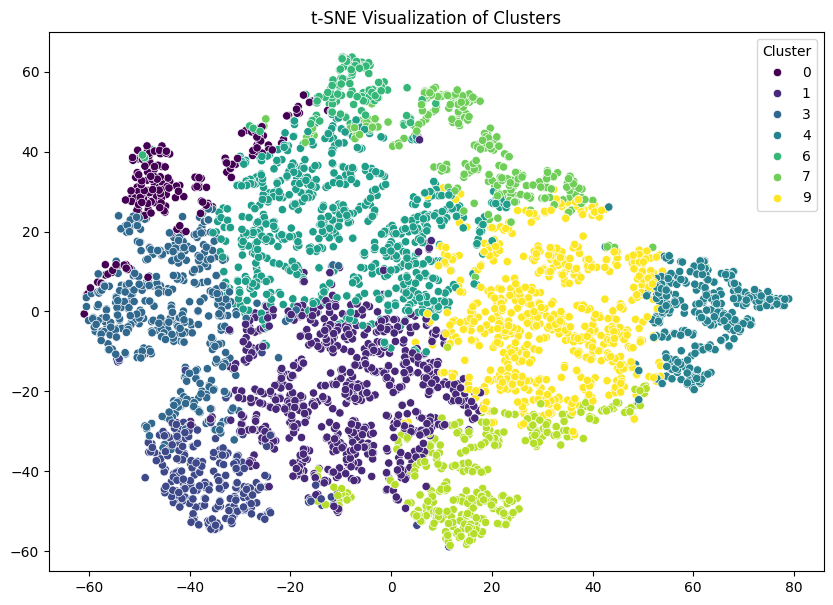

In [14]:

# Step 1: Tokenize cleaned text for Word2Vec training
final['TokenizedText'] = final['CleanedText'].apply(lambda x: x.split())

# Step 2: Train Word2Vec model on tokenized text
word2vec_model = Word2Vec(sentences=final['TokenizedText'], vector_size=100, window=5, min_count=2, workers=4)

# Step 3: Generate review embeddings by averaging word vectors
def get_review_embedding(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

final['ReviewEmbedding'] = final['TokenizedText'].apply(lambda tokens: get_review_embedding(tokens, word2vec_model))
review_embeddings = np.vstack(final['ReviewEmbedding'].values)

# Step 4: Cluster the review embeddings
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
final['Cluster'] = kmeans.fit_predict(review_embeddings)

# Step 5: Evaluate clustering quality with silhouette score
silhouette_avg = silhouette_score(review_embeddings, final['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')

# Step 6: Visualize clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42)
review_embeddings_2d = tsne.fit_transform(review_embeddings)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=review_embeddings_2d[:, 0], y=review_embeddings_2d[:, 1], hue=final['Cluster'], palette="viridis")
plt.title("t-SNE Visualization of Clusters")
plt.show()



In [15]:
from collections import Counter



Cluster 0 Summary:
Most common words: [('tast', 192), ('like', 171), ('flavor', 102), ('chocol', 76), ('coffe', 76), ('good', 41), ('one', 41), ('realli', 40), ('tri', 40), ('great', 38)]
Positive reviews: 93, Negative reviews: 96
Sample reviews:
                                                 Text  Score
13  I really like this stuff. It's good and sweet ...      1
28  I ordered this specifically b/c they said "dar...      0
37  Tastes nothing like Old Bay.  Tastes nothing l...      0

Cluster 1 Summary:
Most common words: [('like', 337), ('one', 322), ('product', 291), ('would', 280), ('tri', 245), ('buy', 244), ('get', 231), ('use', 230), ('tast', 222), ('eat', 221)]
Positive reviews: 313, Negative reviews: 395
Sample reviews:
                                                 Text  Score
0   Sampled this product and found them in my loca...      1
4   The gum that says 'new' is not the same as the...      0
25  Quinoa flakes are used in many gluten-free rec...      1

Cluster 2 Summ

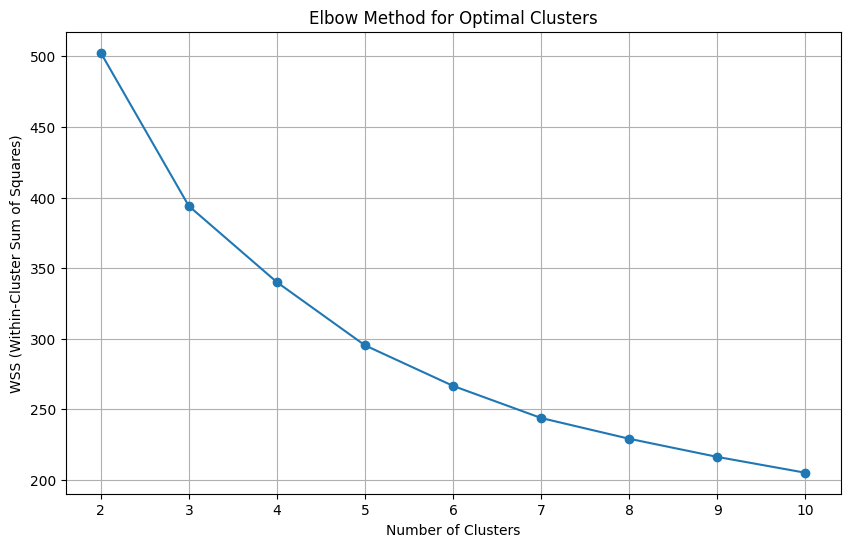

In [16]:
# Step 7: Analyze clusters
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num} Summary:")
    
    # Most common words in each cluster
    cluster_reviews = final[final['Cluster'] == cluster_num]
    cluster_words = " ".join(cluster_reviews['CleanedText'])
    word_counts = Counter(cluster_words.split())
    most_common_words = word_counts.most_common(10)
    print(f"Most common words: {most_common_words}")
    
    # Count positive and negative reviews
    pos_reviews = cluster_reviews[cluster_reviews['Score'] == 1].shape[0]
    neg_reviews = cluster_reviews[cluster_reviews['Score'] == 0].shape[0]
    print(f"Positive reviews: {pos_reviews}, Negative reviews: {neg_reviews}")
    
    # Sample a few reviews from each cluster for inspection
    print("Sample reviews:")
    print(cluster_reviews[['Text', 'Score']].head(3))  # Display top 3 sample reviews

# Step 8: Optional - Visualize WSS (Within-Cluster Sum of Squares) for Elbow Method
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import pairwise_distances_argmin_min

# Calculate WSS for different cluster sizes (if re-tuning the number of clusters)
wss_values = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(review_embeddings)
    wss = kmeans_temp.inertia_
    wss_values.append(wss)

# Plot WSS to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wss_values, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()